In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

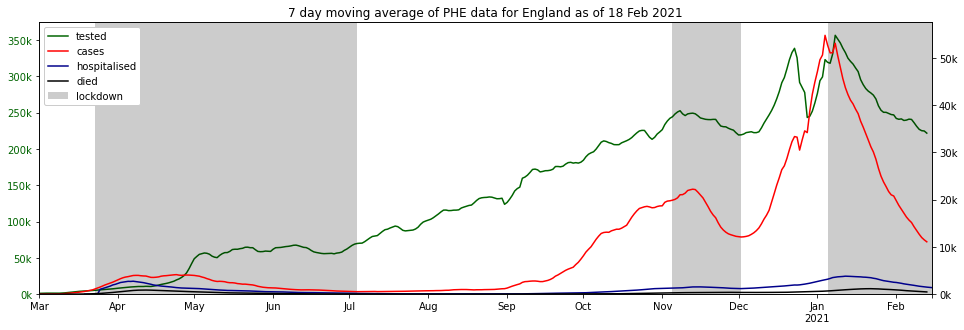

In [35]:
plot_summary(earliest_date='2020-03-01')

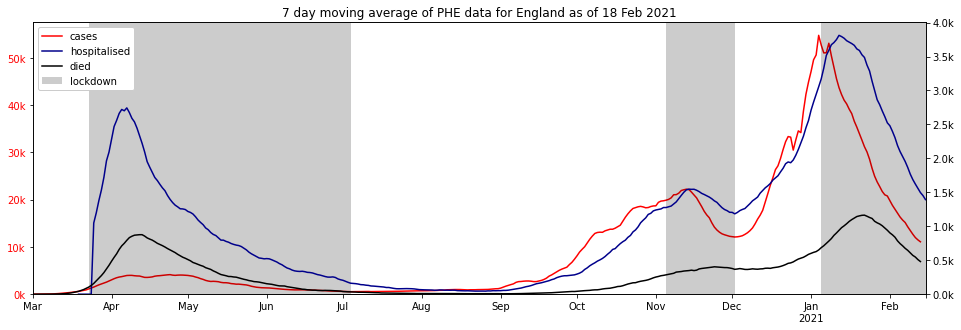

In [36]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,500201.0,13817914.0,13317713.0,56286961,0.888662,23.660387,75.450950
1,Northern Ireland,N92000002,30012.0,427569.0,397557.0,1893667,1.584862,20.994029,77.421109
2,Scotland,S92000003,24169.0,1354966.0,1330797.0,5463300,0.442388,24.358849,75.198763
3,Wales,W92000004,19342.0,822633.0,803291.0,3152879,0.613471,25.478015,73.908513


'partial: 16,423,082'

'full: 573,724'

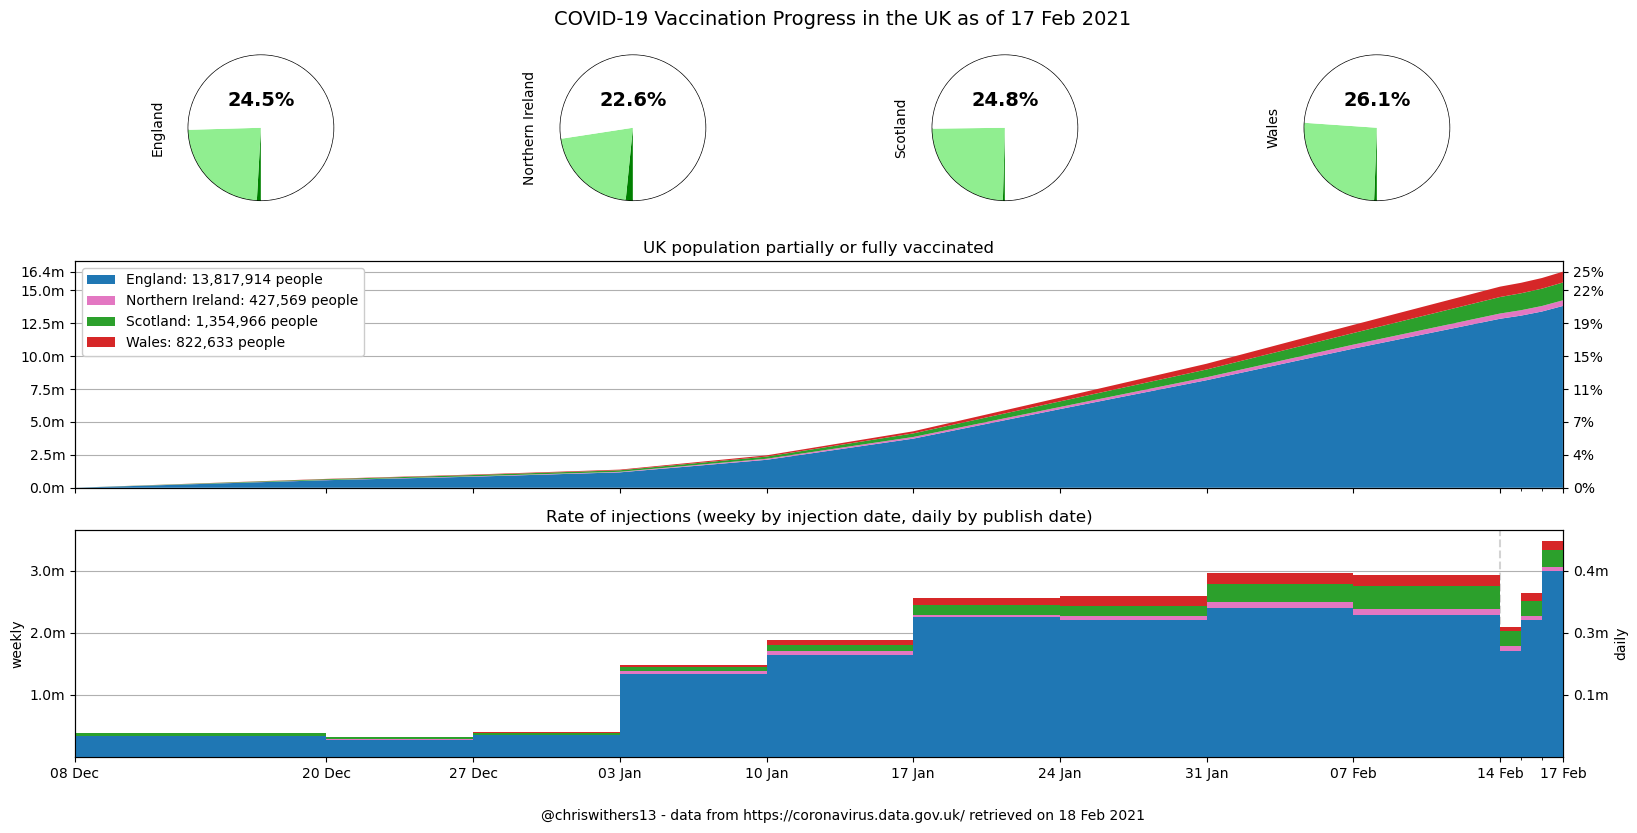

In [37]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [38]:
vaccination_changes()

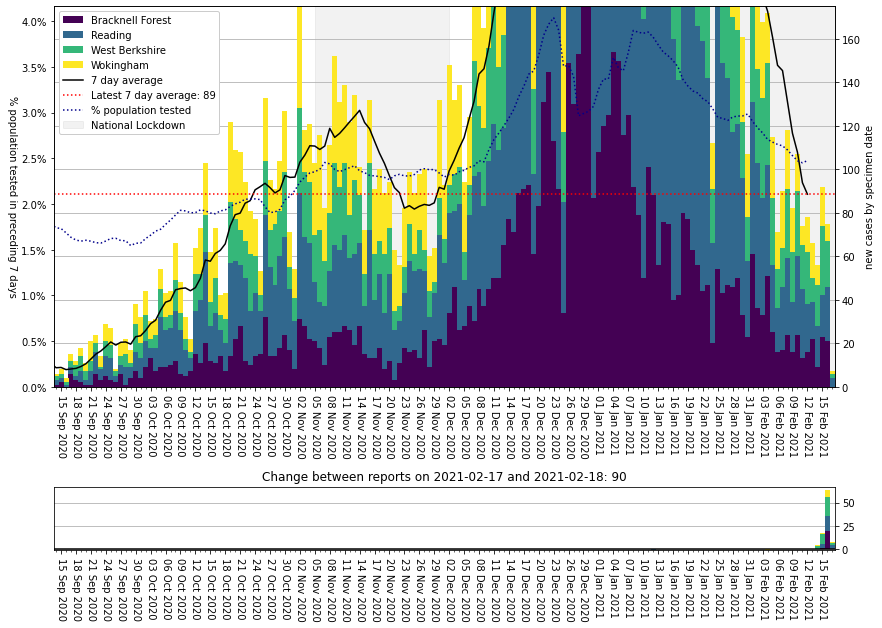

In [39]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=175)

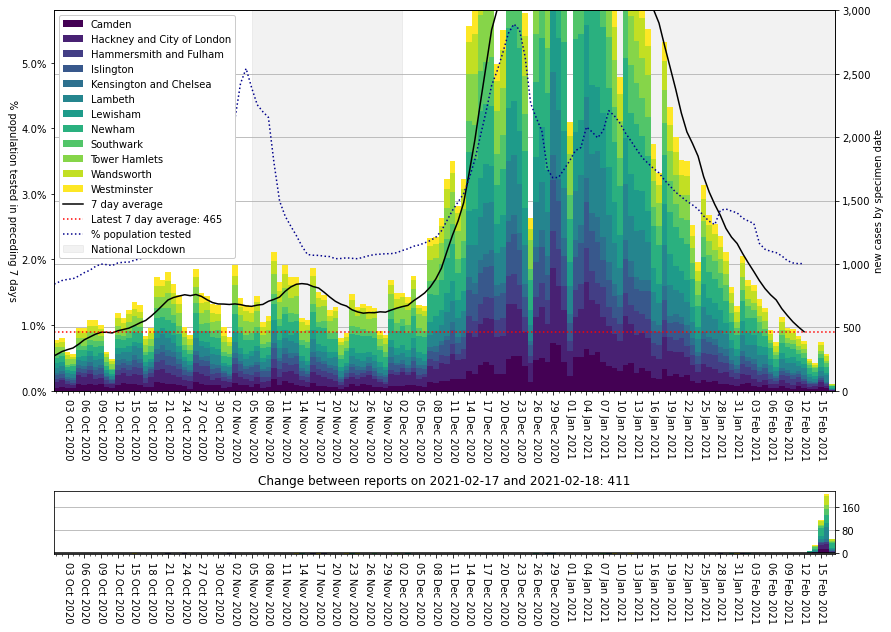

In [40]:
plot_areas(for_date, areas=london_areas, ylim=3_000)

In [41]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [42]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,270.015786,195.0,2021-02-17
E06000002,Middlesbrough,261.739254,369.0,2021-02-17
E08000028,Sandwell,227.127417,746.0,2021-02-17
E06000016,Leicester,220.481955,781.0,2021-02-17
E07000170,Ashfield,219.671977,281.0,2021-02-17
E07000174,Mansfield,218.638222,239.0,2021-02-17
E07000134,North West Leicestershire,213.297816,221.0,2021-02-17
S12000014,Falkirk,210.081422,338.0,2021-02-17
E08000013,St. Helens,208.212199,376.0,2021-02-17


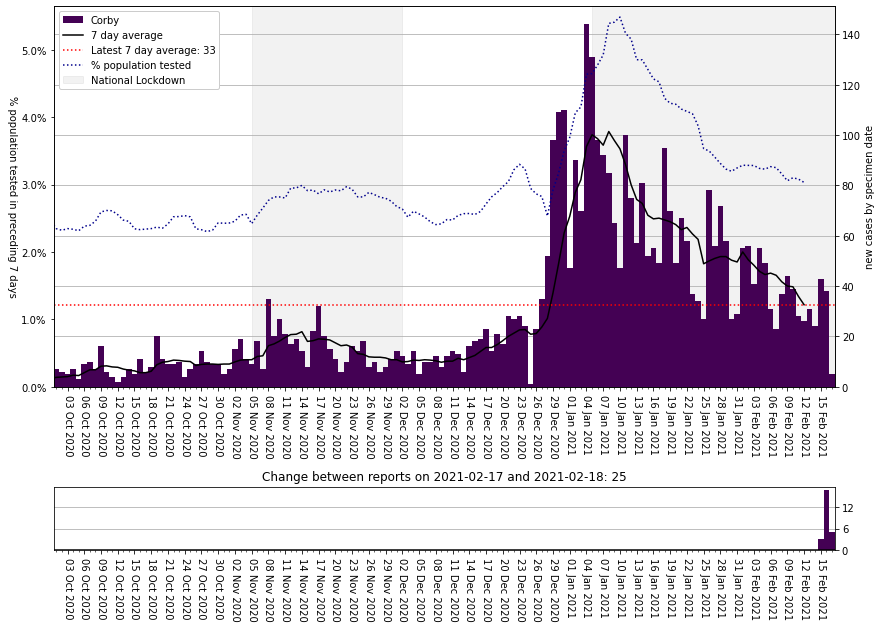

In [43]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [44]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,152.213667,1738.0,2021-02-17
E08000035,Leeds,135.915647,1078.0,2021-02-17
E08000032,Bradford,172.478954,931.0,2021-02-17
E08000003,Manchester,149.586331,827.0,2021-02-17
E06000016,Leicester,220.481955,781.0,2021-02-17
E08000028,Sandwell,227.127417,746.0,2021-02-17
S12000049,Glasgow City,112.616881,713.0,2021-02-17
E08000012,Liverpool,139.948037,697.0,2021-02-17
E06000047,County Durham,126.958615,673.0,2021-02-17


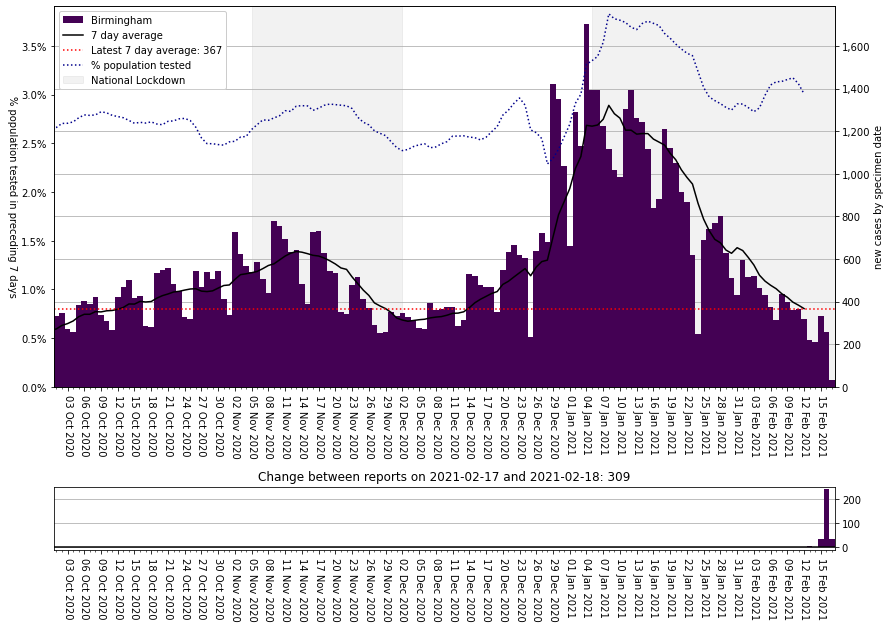

In [45]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [2]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.6
phe_max = 0.35

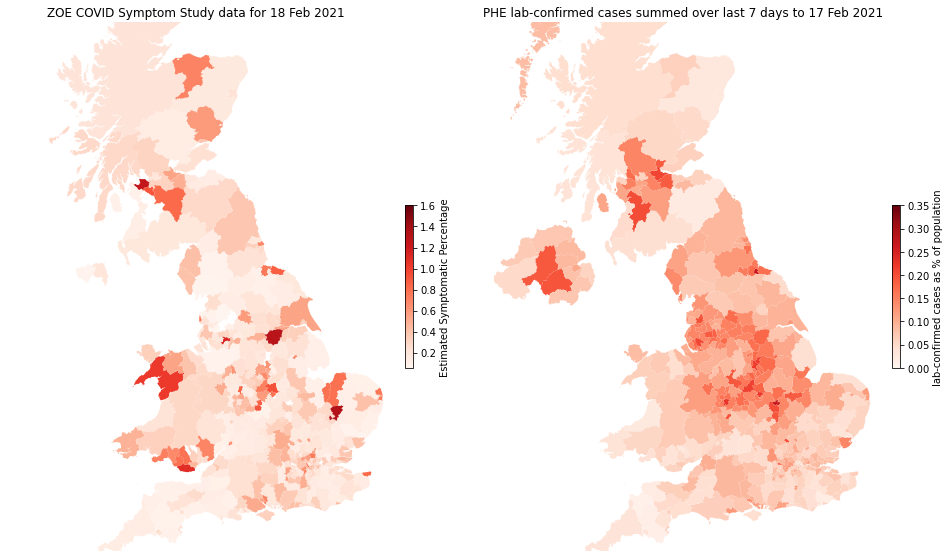

In [3]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [4]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

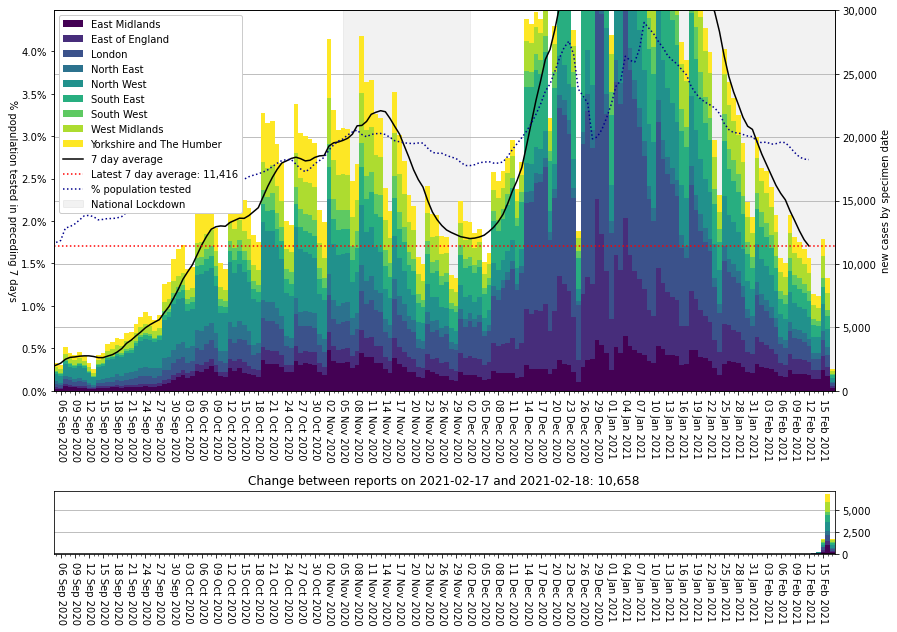

In [49]:
plot_areas(for_date, area_type=region, ylim=30_000, earliest='2020-09-05')

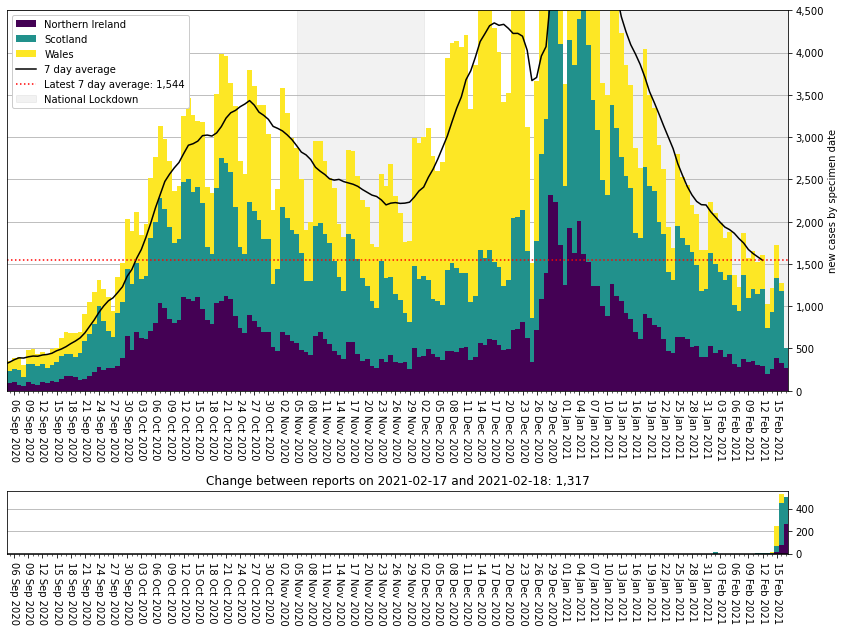

In [50]:
plot_areas(for_date, 'cases_devolved', ylim=4_500, diff_ylims=None, earliest='2020-09-05')